<a href="https://colab.research.google.com/github/segomezz/Practica2-IA/blob/main/Pr%C3%A1ctica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importación y preparación del dataset

El dataset Lending Club contiene información financiera de préstamos otorgados entre 2007 y 2018. Cuenta con más de 2 millones de registros y múltiples variables tanto numéricas como categóricas. La variable objetivo seleccionada es loan_status, que representa el estado final del préstamo y posee más de 10 categorías, de las cuales seleccionamos al menos 4 para abordar el problema como clasificación multiclase. Este conjunto de datos es adecuado para aplicar técnicas de aprendizaje supervisado y no supervisado, ya que permite evaluar el desempeño de los modelos ante clases desbalanceadas y perfiles de riesgo.

In [23]:
import pandas as pd     #Importación de librerías necesarias
import numpy as np
import zipfile
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
drive.mount('/content/drive')
# Cargar el archivo zip directamente
file_path = '/content/drive/MyDrive/2025-I/Introducción a la inteligencia Artificial/Practica 2/accepted_2007_to_2018Q4.csv.gz'

df_full = pd.read_csv(file_path, low_memory=False, compression='gzip')

# Tomar muestra aleatoria (conjunto representativo)
df = df_full.sample(n=20000, random_state=42).reset_index(drop=True)

# Verificación
print(f"Dataset cargado con {df.shape[0]} registros.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset cargado con 20000 registros.


In [3]:
# Ver las clases posibles de loan_status
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,9500
Current,7744
Charged Off,2398
Late (31-120 days),217
In Grace Period,74
Late (16-30 days),48
Does not meet the credit policy. Status:Fully Paid,12
Does not meet the credit policy. Status:Charged Off,7


In [4]:
# Filtrar las clases más frecuentes para convertir esto en clasificación multiclase
selected_statuses = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']
df = df[df['loan_status'].isin(selected_statuses)]

# Eliminar columnas con más del 50% de datos nulos
df = df.loc[:, df.isnull().mean() < 0.5]

# Seleccionar algunas variables numéricas y categóricas representativas
cat_vars = ['grade', 'home_ownership', 'verification_status', 'purpose', 'term']
num_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'revol_util']

df = df[cat_vars + num_vars + ['loan_status']].dropna()

In [5]:
# Cambio de variables categóricas a numéricas con la introducción de una variable dummy
df_encoded = pd.get_dummies(df, columns=cat_vars)

In [6]:
# Estandarización de datos

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df_encoded[num_vars])
df_encoded[num_vars] = num_scaled

In [7]:

# 1. Calcular los z-scores solo de las variables numéricas
z_scores = np.abs(zscore(df_encoded[num_vars]))

# 2. Filtrar el dataset sin outliers (z-score < 3 en TODAS las columnas numéricas)
df_no_outliers = df_encoded[(z_scores < 3).all(axis=1)]

# 3. Determinar cuántas filas queremos como "outliers" (5% del dataset limpio)
n_outliers = int(0.05 * len(df_no_outliers))

# 4. Obtener las filas que fueron eliminadas (los verdaderos outliers detectados)
df_all_outliers = df_encoded[~df_encoded.index.isin(df_no_outliers.index)]

# 5. Tomar una muestra aleatoria de outliers (solo 5%)
# Verifica cuántos outliers realmente tienes disponibles
available_outliers = df_all_outliers.shape[0]
n_outliers_final = min(n_outliers, available_outliers)

# Toma solo los que puedas (sin reemplazo)
df_outliers_5pct = df_all_outliers.sample(n=n_outliers_final, random_state=42)

# 6. Combinar los datos limpios + los outliers seleccionados
df_5pct_outliers = pd.concat([df_no_outliers, df_outliers_5pct])

In [8]:


# Dataset balanceado
min_class = df_no_outliers['loan_status'].value_counts().min()

dfs = []
for status in df_no_outliers['loan_status'].unique():
    df_class = df_no_outliers[df_no_outliers['loan_status'] == status]
    dfs.append(resample(df_class, replace=False, n_samples=min_class, random_state=42))

df_balanced = pd.concat(dfs)

# Dataset desbalanceado (sin modificación)
df_unbalanced = df_no_outliers.copy()

In [9]:
datasets = {}

# Base sin escalado: deshacer el escalado en una copia
df_unscaled = df_encoded.copy()
df_unscaled[num_vars] = df[num_vars]  # recuperamos los valores originales sin escalar

### CASOS 1-4: sin escalado
datasets['1'] = df_no_outliers.copy()                        # No escalado, sin outliers, desbalanceado
datasets['2'] = df_balanced.copy()                           # No escalado, sin outliers, balanceado
datasets['3'] = df_5pct_outliers.copy()                      # No escalado, con 5% outliers, desbalanceado
datasets['4'] = pd.concat([
    df_balanced,
    df_5pct_outliers[df_5pct_outliers['loan_status'].isin(df_balanced['loan_status'].unique())]
]).drop_duplicates().copy()  # Balanceado con 5% outliers

### CASOS 5-8: con escalado (ya aplicado en df_encoded y derivados)
datasets['5'] = df_no_outliers.copy()                        # Escalado, sin outliers, desbalanceado
datasets['6'] = df_balanced.copy()                           # Escalado, sin outliers, balanceado
datasets['7'] = df_5pct_outliers.copy()                      # Escalado, con 5% outliers, desbalanceado
datasets['8'] = pd.concat([
    df_balanced,
    df_5pct_outliers[df_5pct_outliers['loan_status'].isin(df_balanced['loan_status'].unique())]
]).drop_duplicates().copy()  # Escalado, balanceado, con 5% outliers

# 2) Aprendizaje supervisado

# 3) Aprendizaje no supervisado

El procedimiento para llenar la tabla consistirá primero en evaluar para cada dataset la inercia y el silhoutte para decidir con base en eso el mejor número de clusters, una vez determinado eso se procederá al entrenamiento para luego evaluar las métricas

## 3.1) Dataset no escalado, sin outliers y con datos desbalanceados

### K-means

In [60]:
unsupervised_datasets = {} #Creación de dataset que se usarán en el entrenamiento

for i in range(1, 9):
    df_i = datasets[str(i)].drop(columns=['loan_status'])  # quitamos la variable objetivo
    unsupervised_datasets[str(i)] = df_i.copy()

In [61]:
def evaluate_kmeans(X, max_k=12):
    inertias = []
    silhouettes = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))

    return inertias, silhouettes

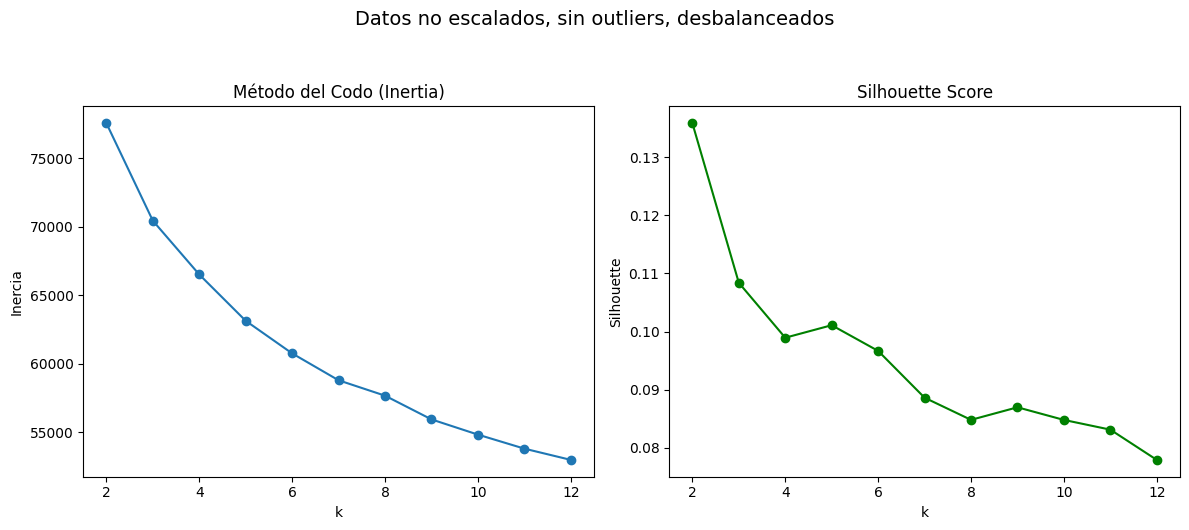

In [62]:
resultados_no_supervisado = []
# Número del dataset (como string)
caso = '1'

# Dataset sin variable objetivo
X = unsupervised_datasets[caso]
inertias, silhouettes = evaluate_kmeans(X)

plt.figure(figsize=(12, 5))

# Título general de toda la figura
plt.suptitle("Datos no escalados, sin outliers, desbalanceados", fontsize=14, y=1.05)

# Subplot 1: Método del Codo
plt.subplot(1, 2, 1)
plt.plot(range(2, 13), inertias, marker='o')
plt.title('Método del Codo (Inertia)')
plt.xlabel('k')
plt.ylabel('Inercia')

# Subplot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 13), silhouettes, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()

In [63]:
kmeans1 = KMeans(n_clusters=4, random_state=42)
labels_kmeans1 = kmeans1.fit_predict(X)

print("Inertia:", kmeans1.inertia_)
print("Silhouette Score:", silhouette_score(X, labels_kmeans1))

Inertia: 66512.34069475126
Silhouette Score: 0.0989494919096706


### DBSCAN

In [64]:
def estimate_epsilon(X):
    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)
    distances = np.sort(distances[:, 4])  # distancia al 5to vecino
    plt.figure(figsize=(6, 4))
    plt.plot(distances)
    plt.title('Distancias al 5to vecino más cercano')
    plt.xlabel('Muestra ordenada')
    plt.ylabel('Distancia')
    plt.show()

In [65]:
db1 = DBSCAN(eps=1.56, min_samples=5)
labels_dbscan1 = db1.fit_predict(X)

# -1 indica "ruido"
n_clusters = len(set(labels_dbscan1)) - (1 if -1 in labels_dbscan1 else 0)
silhouette_DBSCAN1= silhouette_score(X, labels_dbscan1)
print("Clusters encontrados:", n_clusters)

print("Silhouette Score (DBSCAN):", silhouette_DBSCAN1)
# Guardar resultados
resultados_no_supervisado.append({
    'Caso': caso,
    'Inercia_KMeans': kmeans1.inertia_,
    'Silhouette_KMeans': silhouette_score(X, labels_kmeans1),
    'Silhouette_DBSCAN': silhouette_DBSCAN1
})


Clusters encontrados: 6
Silhouette Score (DBSCAN): -0.13345105319559133


## 3.2) Dataset No escalado, sin outliers, balanceado

### K-means

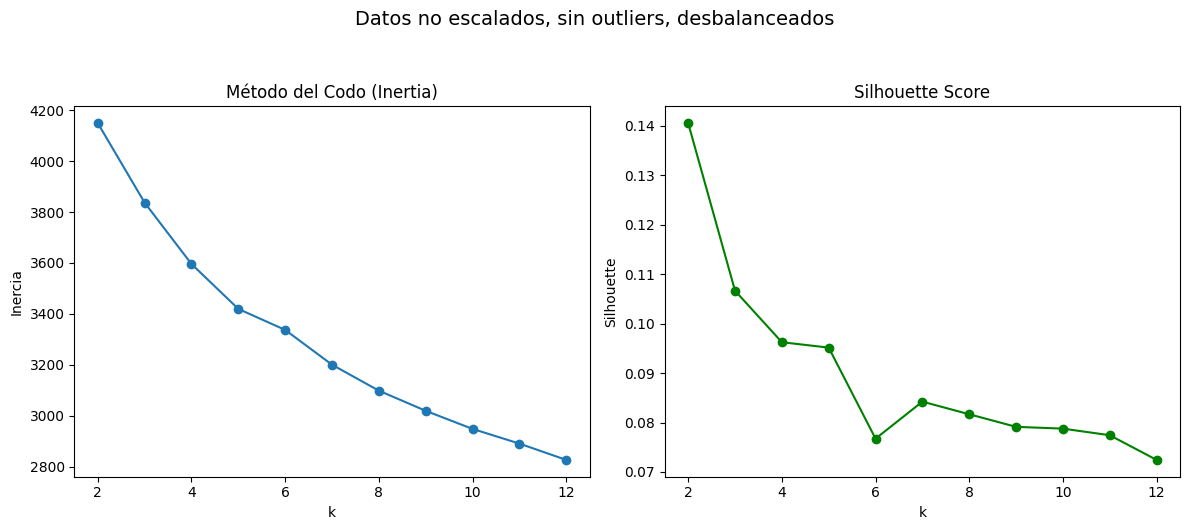

Inertia: 3595.834214454392
Silhouette Score: 0.09624840481028052


In [66]:
def evaluate_kmeans(X, max_k=12):
    inertias = []
    silhouettes = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))

    return inertias, silhouettes

# Número del dataset (como string)
caso = '2'

# Dataset sin variable objetivo
X = unsupervised_datasets[caso]
inertias, silhouettes = evaluate_kmeans(X)

plt.figure(figsize=(12, 5))

# Título general de toda la figura
plt.suptitle("Datos no escalados, sin outliers, desbalanceados", fontsize=14, y=1.05)

# Subplot 1: Método del Codo
plt.subplot(1, 2, 1)
plt.plot(range(2, 13), inertias, marker='o')
plt.title('Método del Codo (Inertia)')
plt.xlabel('k')
plt.ylabel('Inercia')

# Subplot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 13), silhouettes, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()
kmeans2 = KMeans(n_clusters=4, random_state=42)
labels_kmeans2 = kmeans2.fit_predict(X)

print("Inertia:", kmeans2.inertia_)
print("Silhouette Score:", silhouette_score(X, labels_kmeans2))


### DBSCAN

In [67]:
db2 = DBSCAN(eps=1.56, min_samples=5)
labels_dbscan2 = db2.fit_predict(X)

# -1 indica "ruido"
n_clusters = len(set(labels_dbscan2)) - (1 if -1 in labels_dbscan2 else 0)
silhouette_DBSCAN2= silhouette_score(X, labels_dbscan2)
print("Clusters encontrados:", n_clusters)

print("Silhouette Score (DBSCAN):", silhouette_DBSCAN2)
# Guardar resultados
resultados_no_supervisado.append({
    'Caso': caso,
    'Inercia_KMeans': kmeans2.inertia_,
    'Silhouette_KMeans': silhouette_score(X, labels_kmeans2),
    'Silhouette_DBSCAN': silhouette_DBSCAN2
})

Clusters encontrados: 8
Silhouette Score (DBSCAN): -0.2033869411299773


In [68]:
print(resultados_no_supervisado)

[{'Caso': '1', 'Inercia_KMeans': 66512.34069475126, 'Silhouette_KMeans': np.float64(0.0989494919096706), 'Silhouette_DBSCAN': np.float64(-0.13345105319559133)}, {'Caso': '2', 'Inercia_KMeans': 3595.834214454392, 'Silhouette_KMeans': np.float64(0.09624840481028052), 'Silhouette_DBSCAN': np.float64(-0.2033869411299773)}]


## 3.3) Dataset No escalado, con outliers (5%) y desbalanceado

### K-means

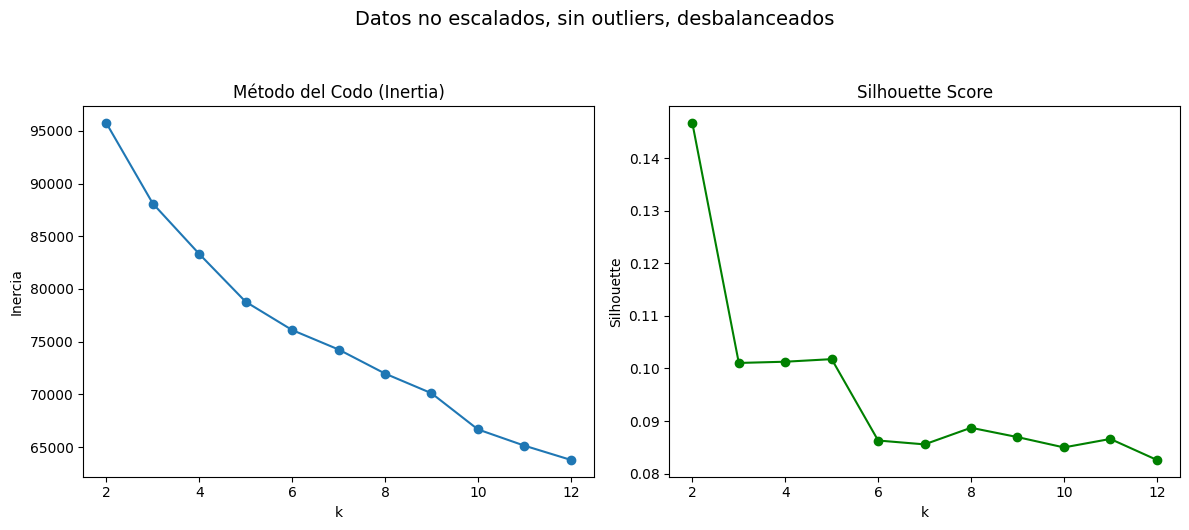

In [69]:
# Número del dataset (como string)
caso = '3'

# Dataset sin variable objetivo
X = unsupervised_datasets[caso]
inertias, silhouettes = evaluate_kmeans(X)

plt.figure(figsize=(12, 5))

# Título general de toda la figura
plt.suptitle("Datos no escalados, sin outliers, desbalanceados", fontsize=14, y=1.05)

# Subplot 1: Método del Codo
plt.subplot(1, 2, 1)
plt.plot(range(2, 13), inertias, marker='o')
plt.title('Método del Codo (Inertia)')
plt.xlabel('k')
plt.ylabel('Inercia')

# Subplot 2: Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 13), silhouettes, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()



In [ ]:
kmeans2 = KMeans(n_clusters=4, random_state=42)
labels_kmeans2 = kmeans2.fit_predict(X)

print("Inertia:", kmeans2.inertia_)
print("Silhouette Score:", silhouette_score(X, labels_kmeans2))